In [1]:
import torch
from torch.nn.functional import normalize

import open_clip

import cv2
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

from sqb.tools import extract_character, remove_empty_area

In [2]:
# open_clip.list_pretrained()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# model, preprocess = clip.load(backbone, device=device)

# backbone = ('ViT-H-14-quickgelu', 'dfn5b')
backbone = ('ViT-L-14-quickgelu', 'dfn2b')

model, _, preprocess = open_clip.create_model_and_transforms(backbone[0], pretrained=backbone[1], device=device)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-23): 24 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-05, elementwise_affine=Tru

In [4]:
@torch.inference_mode()
def get_image_embedding(image):
    image = preprocess(image).unsqueeze(0).to(device)
    return normalize(model.encode_image(image), p=2.0)

def get_query_embedding(query_image_path):
    query_image = extract_character(query_image_path)
    query_image = remove_empty_area(query_image)
    query_image = Image.fromarray(query_image[..., ::-1])
    return get_image_embedding(query_image).reshape(1, -1), query_image

def get_similar_images(query_image_path: Path, top_k: int = 5):
    query_embedding, query_image = get_query_embedding(query_image_path)

    similarity = (100.0 * query_embedding @ documents_embeddings.T).softmax(dim=-1, dtype=torch.float32)

    _, indices = similarity[0].topk(top_k)
    indices = indices.cpu().numpy()

    top_images = [document_images[index] for index in indices]
    top_images.insert(0, query_image)

    return top_images

In [5]:
document_images = sorted(Path('character_images').glob('*/*.png'))

documents_embeddings = torch.cat([get_image_embedding(Image.open(path)) for path in tqdm(document_images)], dim=0)
documents_embeddings.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 567/567 [00:49<00:00, 11.50it/s]


torch.Size([567, 768])

In [6]:
top_k: int = 5

test_path = r'C:\\Users\zero\Pictures\MapleStory Worlds'

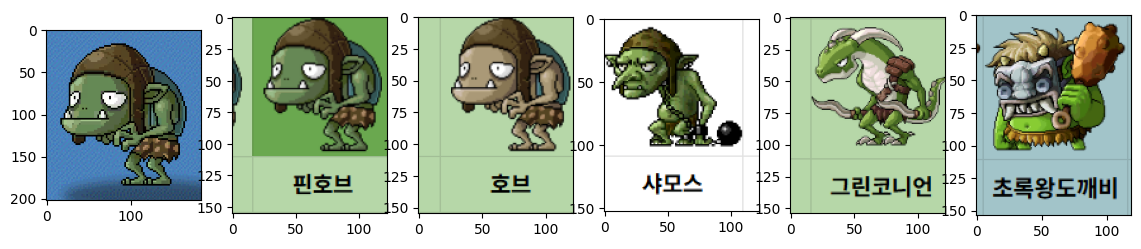

CPU times: total: 1 s
Wall time: 495 ms


In [56]:
%%time
test_images = sorted(Path(test_path).glob('*.png'), reverse=True)

fig = plt.figure(figsize=(14, 32))

top_images = get_similar_images(test_images[0], top_k=top_k)

for i, image in enumerate(top_images):
    fig.add_subplot(1, top_k + 1, i + 1)
    if i == 0:
        plt.imshow(np.array(image))
    else:
        plt.imshow(cv2.imread(image)[..., ::-1])

plt.show()

# EOF

In [1]:
test_images: list[Path] = sorted(Path('tests').glob('*.png'), reverse=True)
# test_images = sorted(Path(test_path).glob('*.png'), reverse=True)

results = []
for test_image in test_images:
    results.extend([
        cv2.imread(image)[..., ::-1] if i > 0 else np.array(image)
        for i, image in enumerate(get_similar_images(test_image, top_k=top_k))
    ])

NameError: name 'Path' is not defined

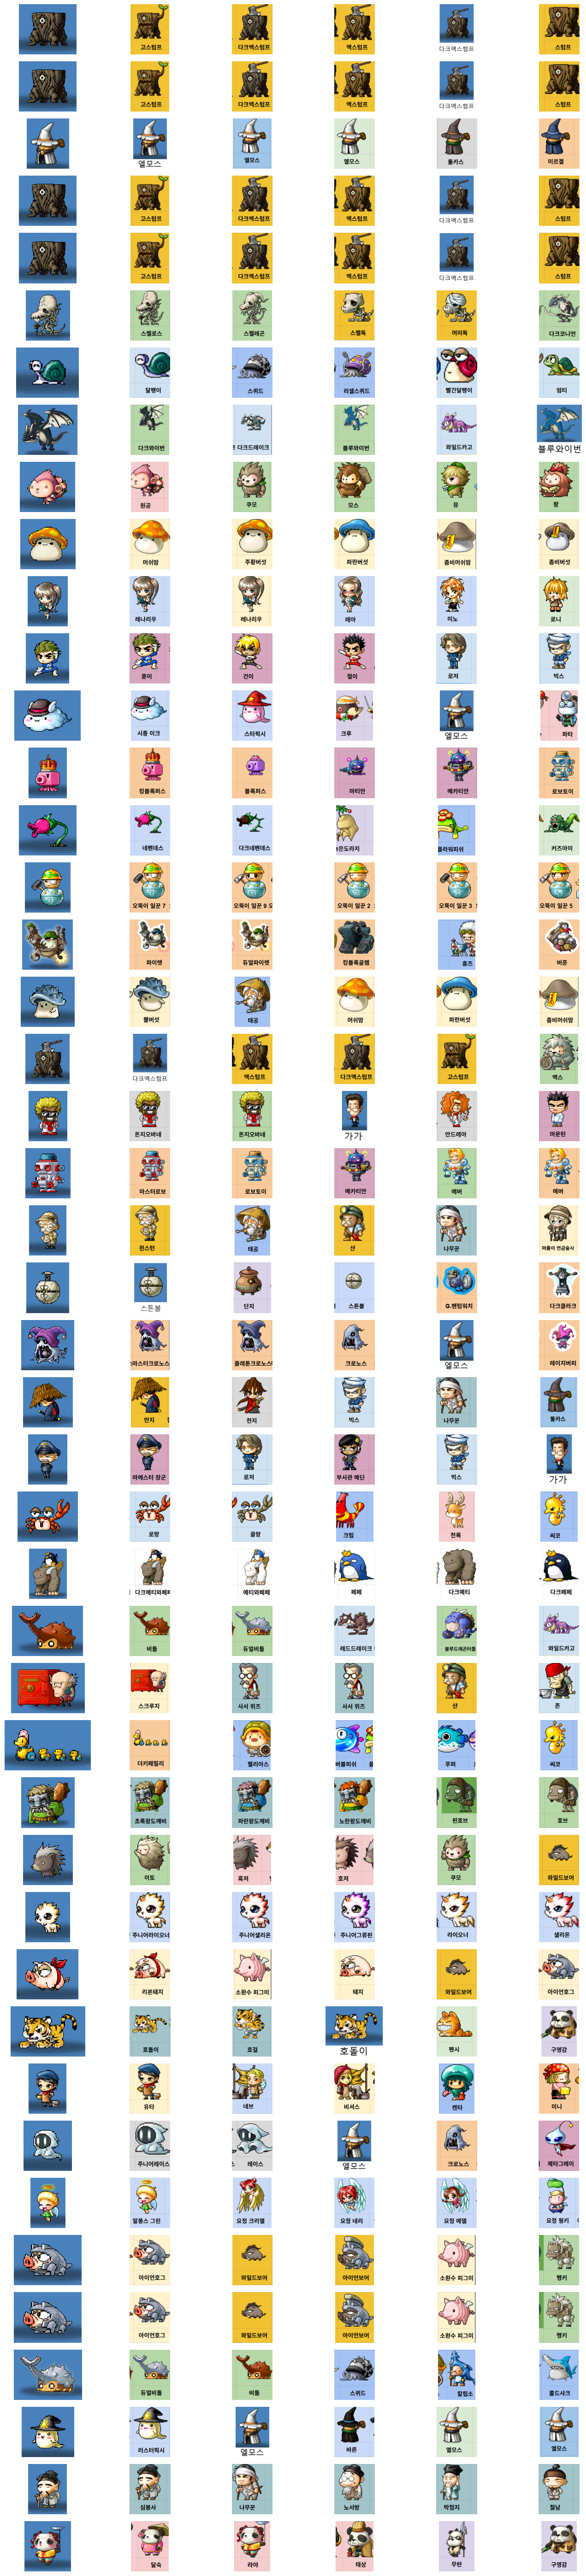

In [8]:
fig, axes = plt.subplots(len(test_images), top_k + 1, figsize=(14, 56))

for idx, ax in enumerate(axes.flat):
    ax.imshow(results[idx])
    ax.axis('off')

plt.tight_layout()
plt.show()

# EOF